# Core Features: Import

In [1]:
# code from this library - import the lines module
import loss_landscapes
import loss_landscapes.metrics
from loss_landscapes.metrics.metric import Metric
from loss_landscapes.model_interface.model_wrapper import ModelWrapper, wrap_model
from loss_landscapes.model_interface.model_parameters import ModelParameters, rand_u_like, rand_n_like, orthogonal_to
from loss_landscapes.contrib.functions import SimpleWarmupCaller, SimpleLossEvalCaller, log_refined_loss

In [2]:
from pyhessian.utils import *
from pyhessian import hessian, get_esd_plot, density_generate # ESD plot

In [3]:
from segmentationCRF import metrics
from segmentationCRF.models import UNet
from segmentationCRF.data_utils import get_datset, get_default_transforms
from segmentationCRF.utils import check_make_dir
from segmentationCRF import test
from segmentationCRF.crfseg import CRF

In [4]:
# libraries
import copy
import sys
import os
from typing import List
import time
import random
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils
from torchinfo import summary
from tqdm import tqdm

matplotlib.rcParams['figure.figsize'] = [18, 12]

## 1. Preliminary: Define Parameters

In [5]:
# Hyper-parameters
data_path = "/global/cfs/cdirs/m636/geshi/data/"
input_size = 224
batch_size=32
n_workers = 0
classes = ('foreground', 'background', 'border')
n_classes = len(classes)

data_transform, target_transform = get_default_transforms('oxford', input_size, n_classes, noise_level=0)

In [6]:
# model architecture hyperparameters
downward_params = {
    'in_channels': 3, 
    'emb_sizes': [32, 64, 128, 256, 512], 
    'out_channels': [32, 64, 128, 256, 512],
    'kernel_sizes': [3, 3, 3 ,3 ,3], 
    'paddings': [1, 1, 1, 1, 1], 
    'batch_norm_first': False,
}
upward_params = {
    'in_channels': [512, 1024, 512, 256, 128],
    'emb_sizes': [1024, 512, 256, 128, 64], 
    'out_channels': [512, 256, 128, 64, 32],
    'kernel_sizes': [3, 3, 3, 3, 3], 
    'paddings': [1, 1, 1, 1, 1], 
    'batch_norm_first': False, 
    'bilinear': True,
}
output_params = {
    'in_channels': 64,
    'n_classes': n_classes,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# contour plot resolution
STEPS = 20
RANDOM = 'normal'
NORM = 'layer'
DIST = 0.01
use_hessian = True

In [8]:
unet_crf_path = '/global/cfs/cdirs/m636/geshi/exp/Oxford/crf/CrossEntropy/0_seed_9999/iter30-11-17-2023-19:03:26.pt'
unet_path = '/global/cfs/cdirs/m636/geshi/exp/Oxford/non-crf/CrossEntropy/0_seed_9999/iter30-11-17-2023-18:04:01.pt'

In [9]:
dataset_parameters = {
    'data_path': data_path,
    'split': 'trainval',
    'data_transform': data_transform,
    'target_transform': target_transform,
    'download': True,
}

val_dataset_parameters = {
    'data_path': data_path,
    'split': 'test',
    'data_transform': data_transform,
    'target_transform': target_transform,
    'download': True,
}

dataset = get_datset('oxford', dataset_parameters)
val_dataset = get_datset('oxford', val_dataset_parameters)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)

## 2. Model construction and evaluation

In [10]:
x = torch.rand(1, 3, input_size, input_size)
unet = UNet(downward_params, upward_params, output_params)
unet_crf = nn.Sequential(
    UNet(downward_params, upward_params, output_params),
    CRF(n_spatial_dims=2)
)
out = unet(x)
print('unet output shape', out.shape) 
out = unet_crf(x)
print('unet-crf output shape', out.shape) 

unet output shape torch.Size([1, 3, 224, 224])
unet-crf output shape torch.Size([1, 3, 224, 224])


In [11]:
unet = unet.to(device)
unet.eval()

checkpoint = torch.load(unet_path, map_location=device)
unet.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [12]:
unet_crf = unet_crf.to(device)
unet_crf.eval()

checkpoint = torch.load(unet_crf_path, map_location=device)
unet_crf.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [13]:
model = nn.Sequential(
    unet,
    unet_crf[1]
)
test(model, val_dataloader, n_classes, device)

Test : 100%|██████████| 115/115 [00:44<00:00,  2.61batch/s, accuracy=88.6]

Testing complete in 0m 44s, Test Acc: 88.57300769538703, Test Iou: 0.7414747037681136


(array([0.84820082, 0.8542954 , 0.52192789]),
 {'test_acc': 88.57300769538703,
  'test_homogeneity': 0.027054579519842133,
  'test_frequency_weighted_IOU': 0.8002138736530479,
  'test_mean_IOU': 0.7414747037681136})

In [14]:
criterion = torch.nn.CrossEntropyLoss() # DiceLoss(True), IOULoss(softmax=True)
model_final = copy.deepcopy(model)

In [15]:
x, y = iter(dataloader).__next__()
metric = loss_landscapes.metrics.Loss(criterion, x.to(device), y.to(device))

## 3. UNet CRF-transplant 2D Loss Landscapes

### 3.1 PyHessian Directions and Spectrum

In [16]:
hessian_comp = hessian(model_final,
                       criterion,
                       data=(x.to(device), y.to(device)),
                       device=device)
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)

dir_one = ModelParameters(top_eigenvector[0])
dir_two = ModelParameters(top_eigenvector[1])

/global/homes/g/geshi/.conda/envs/CRF_GPU_Env/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/torch/csrc/autograd/engine.cpp:1059.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [17]:
trace = hessian_comp.trace()
print("The trace of this model is: %.4f"%(np.mean(trace)))

The trace of this model is: 528.5359


In [18]:
density_eigen, density_weight = hessian_comp.density()

In [19]:
density, grids = density_generate(density_eigen, density_weight)

/global/u2/g/geshi/loss-landscapes-segmentation/pyhessian/density_plot.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


/global/homes/g/geshi/.conda/envs/CRF_GPU_Env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/global/homes/g/geshi/.conda/envs/CRF_GPU_Env/lib/python3.9/site-packages/matplotlib/transforms.py:2860: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
/global/homes/g/geshi/.conda/envs/CRF_GPU_Env/lib/python3.9/site-packages/matplotlib/text.py:897: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(self._x))
/global/homes/g/geshi/.conda/envs/CRF_GPU_Env/lib/python3.9/site-packages/matplotlib/text.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  posx = float(self.convert_xunits(self._x))


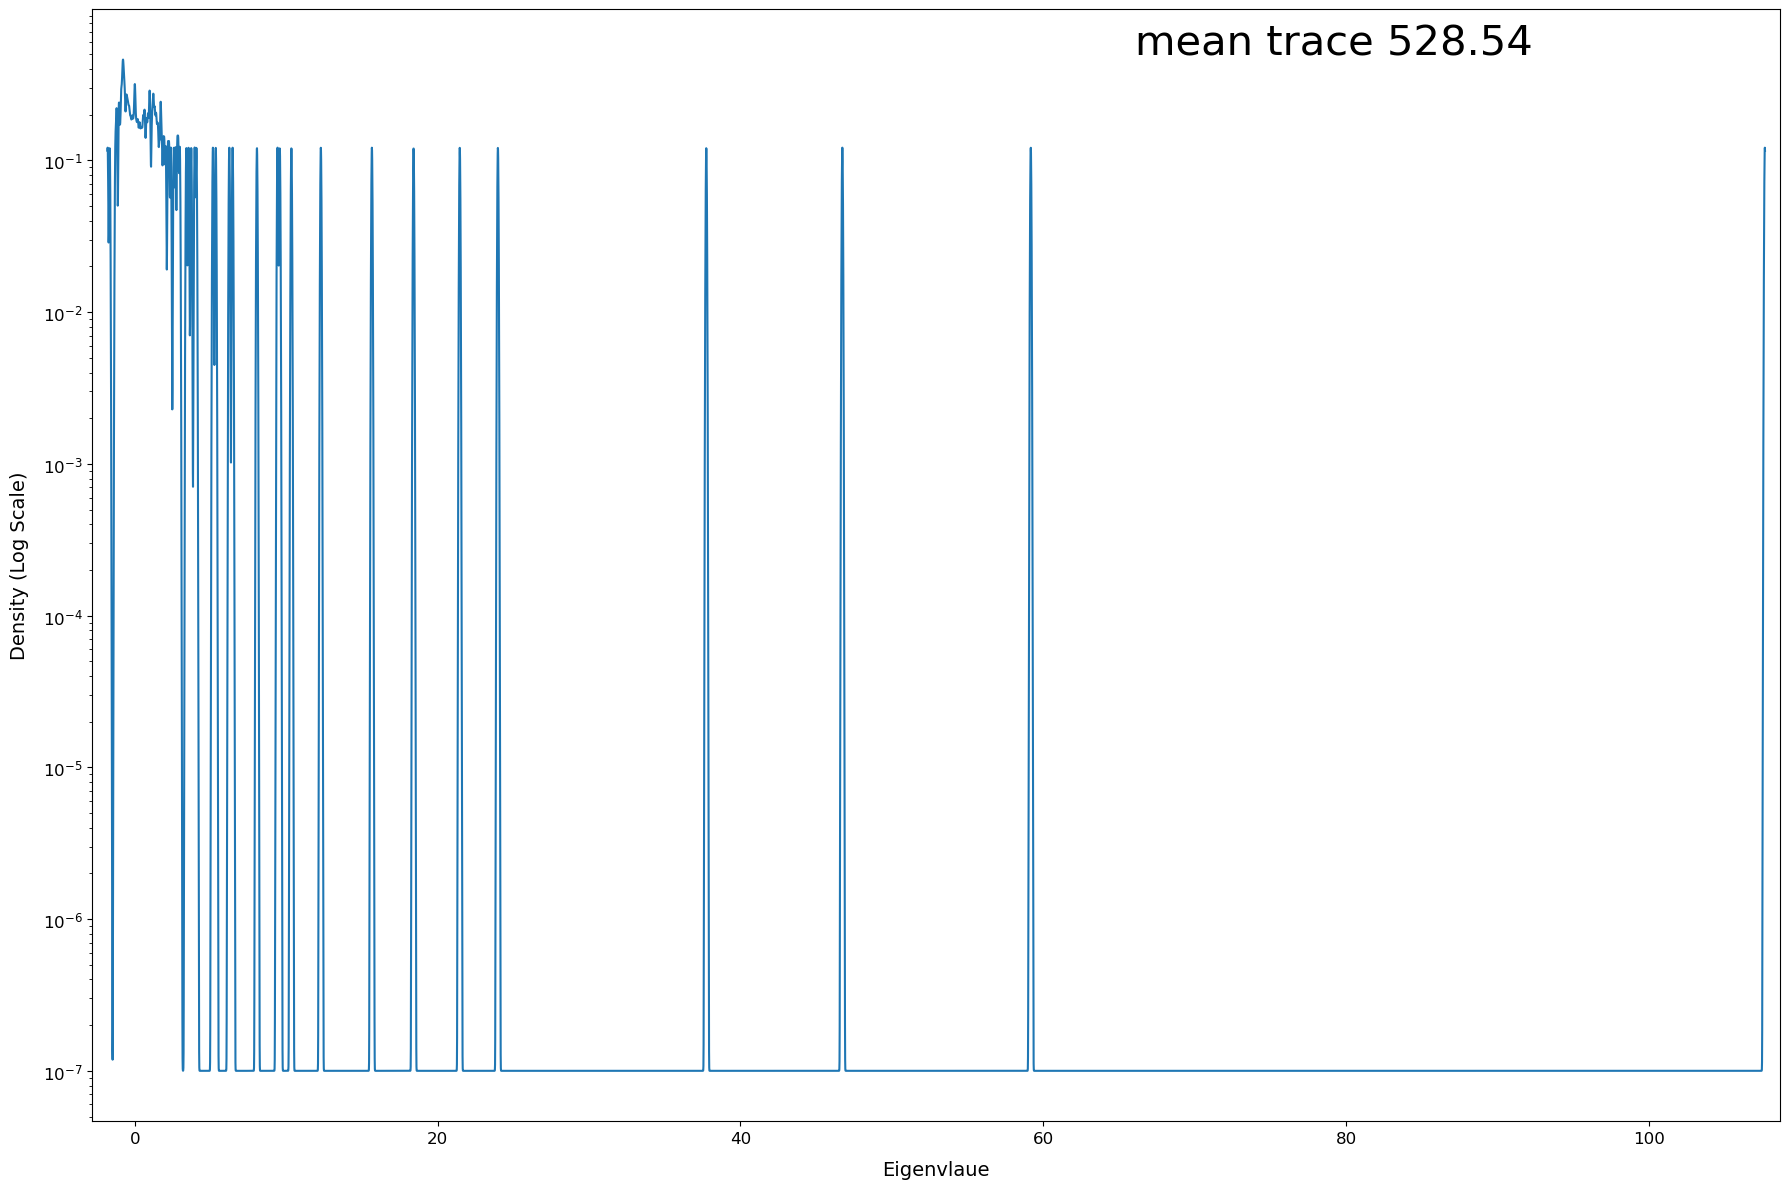

In [20]:
plt.semilogy(grids, density + 1.0e-7)
plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
plt.xlabel('Eigenvlaue', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axis([np.min(density_eigen) - 1, np.max(density_eigen) + 1, None, None])
plt.text(
        (np.max(density_eigen)+1)*0.85,
        1 - 0.5,
        ("mean trace %.2f" % np.mean(trace)).lstrip("0"),
        size=30,
        horizontalalignment="right",
    )
plt.tight_layout()
plt.show()

### 3.2. 2D Loss Landscape by PyHessian Directions

In [21]:
# compute loss data
pll = loss_landscapes.PlanarLossLandscape(model_final, STEPS, deepcopy_model=True)
pll.precomputed(dir_one, dir_two, distance=DIST, normalization=NORM, centered=True)
pll.stats_initializer()

In [22]:
# single batch loss landscape
since = time.time()
pll.warm_up(metric)
print('warmup time cost ', time.time()-since)

since = time.time()
loss_data = pll.compute(metric)
print('compute time cost ', time.time()-since)

warmup time cost  44.587825298309326
compute time cost  42.81717777252197


In [23]:
# loss_data_fin = log_refined_loss(loss_data)
loss_data_fin = loss_data

The loss values on this plane can be visualized in an intuitive and interpretable manner using contour plots or 3D surface plots:

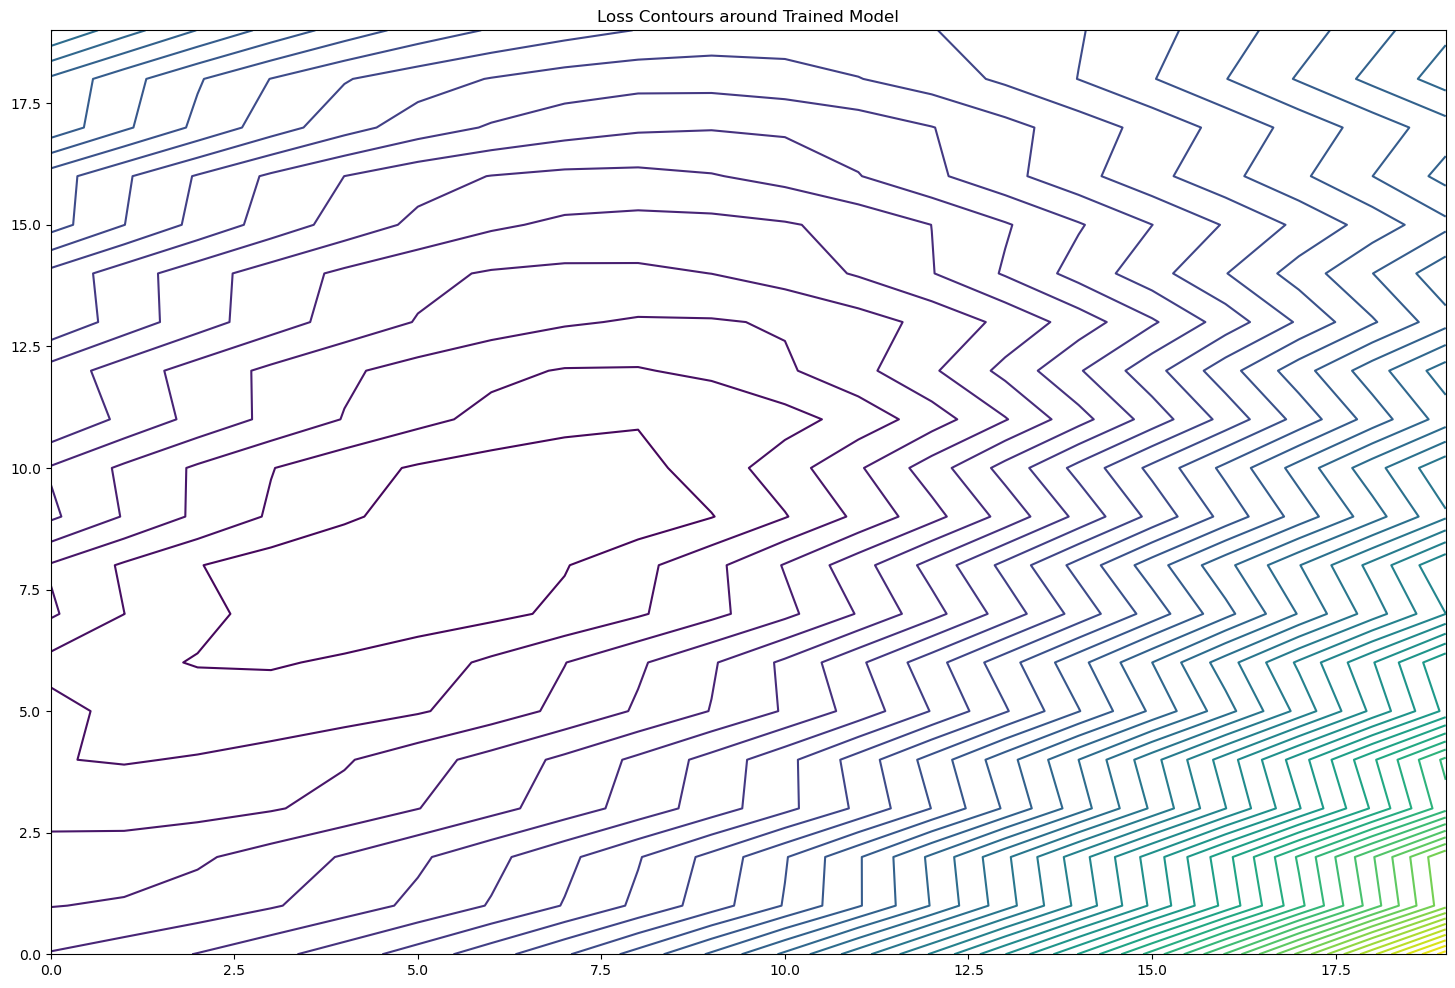

In [24]:
plt.contour(loss_data_fin, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

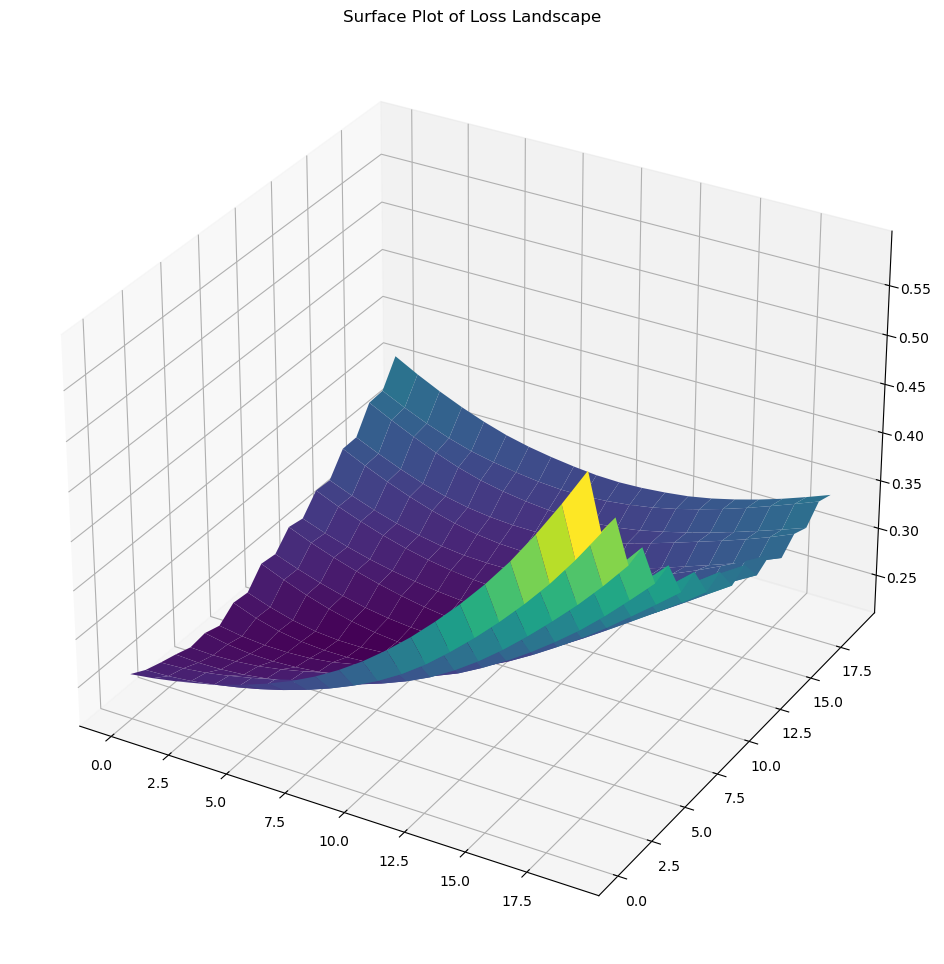

In [25]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

In [26]:
with open('pyhessian-unet-transplant-crf-loss-landscape.npy', 'wb') as f:
    np.save(f, loss_data_fin)

In [27]:
unet_final = model_final[0]
crf_final = model_final[1]

## 4. UNet 2D Loss Landscapes

### 4.1 PyHessian Directions and Spectrum

In [28]:
hessian_comp = hessian(unet_final,
                       criterion,
                       data=(x.to(device), y.to(device)),
                       device=device)
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)

dir_one = ModelParameters(top_eigenvector[0])
dir_two = ModelParameters(top_eigenvector[1])

In [29]:
trace = hessian_comp.trace()
print("The trace of this model is: %.4f"%(np.mean(trace)))

The trace of this model is: 432.5950


In [30]:
density_eigen, density_weight = hessian_comp.density()

In [31]:
density, grids = density_generate(density_eigen, density_weight)

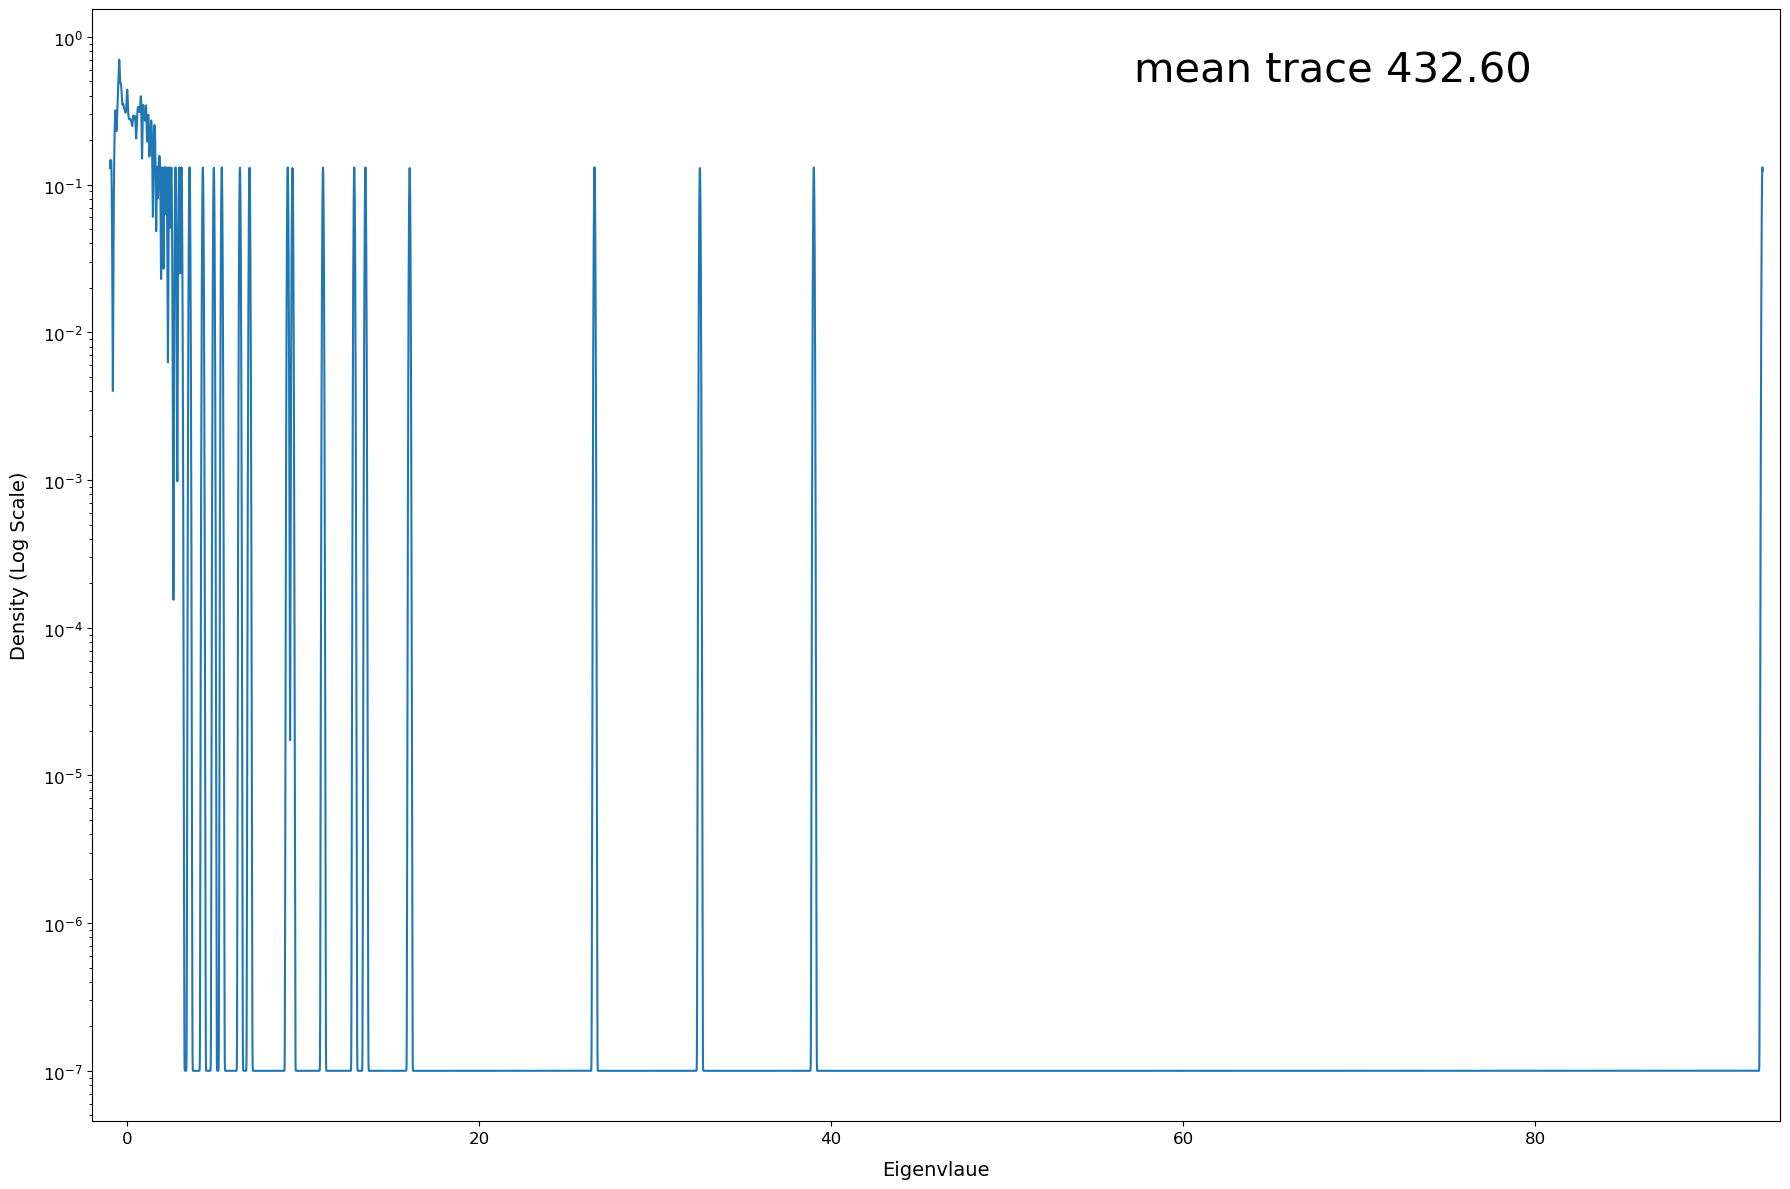

In [32]:
plt.semilogy(grids, density + 1.0e-7)
plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
plt.xlabel('Eigenvlaue', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axis([np.min(density_eigen) - 1, np.max(density_eigen) + 1, None, None])
plt.text(
        (np.max(density_eigen)+1)*0.85,
        1 - 0.5,
        ("mean trace %.2f" % np.mean(trace)).lstrip("0"),
        size=30,
        horizontalalignment="right",
    )
plt.tight_layout()
plt.show()

### 4.2. 2D Loss Landscape by PyHessian Directions

In [33]:
# compute loss data
pll_unet = loss_landscapes.PlanarLossLandscape(unet_final, STEPS, deepcopy_model=True)
pll_unet.precomputed(dir_one, dir_two, distance=DIST, normalization=NORM, centered=True)
pll_unet.stats_initializer()

In [34]:
# single batch loss landscape
since = time.time()
pll_unet.warm_up(metric)
print('warmup time cost ', time.time()-since)

since = time.time()
loss_data_unet = pll_unet.compute(metric)
print('compute time cost ', time.time()-since)

warmup time cost  13.723222970962524
compute time cost  11.652007818222046


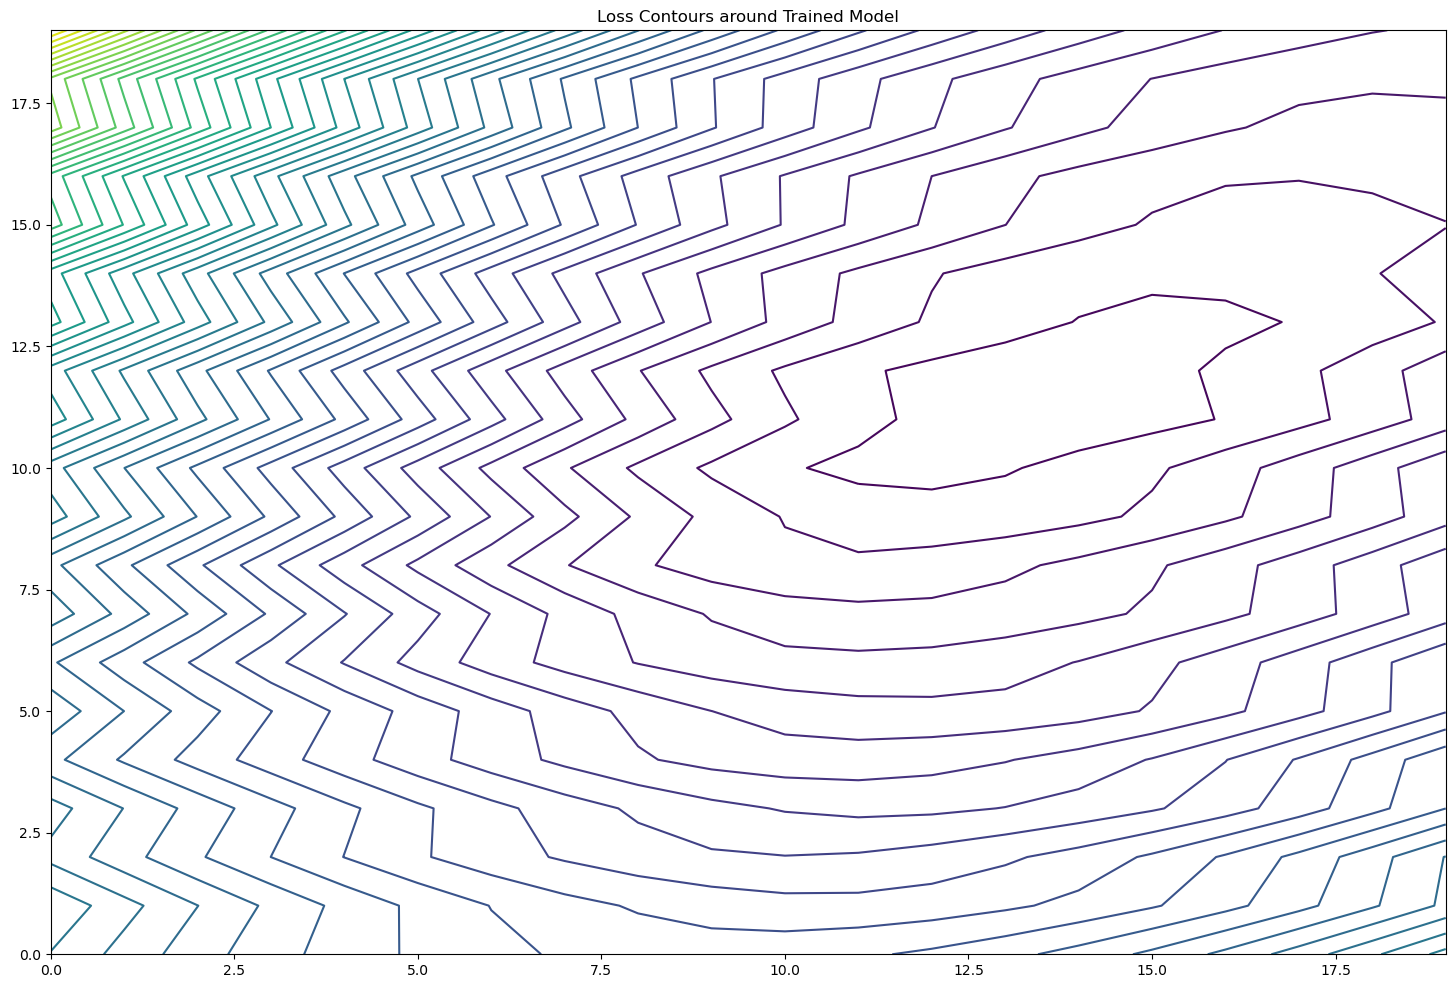

In [35]:
plt.contour(loss_data_unet, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

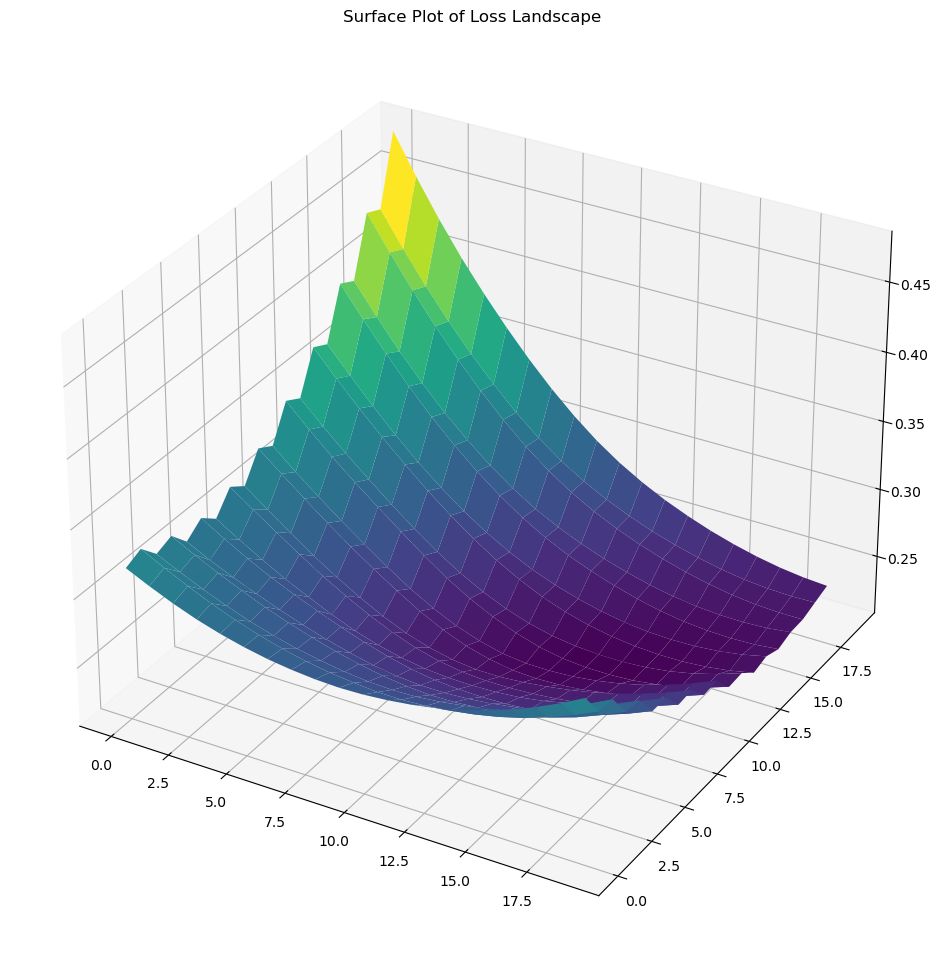

In [36]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_unet, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

In [37]:
with open('pyhessian-unet-loss-landscape.npy', 'wb') as f:
    np.save(f, loss_data_unet)

## 5. 4 - 3

In [38]:
loss_data_diff = loss_data_fin - loss_data_unet

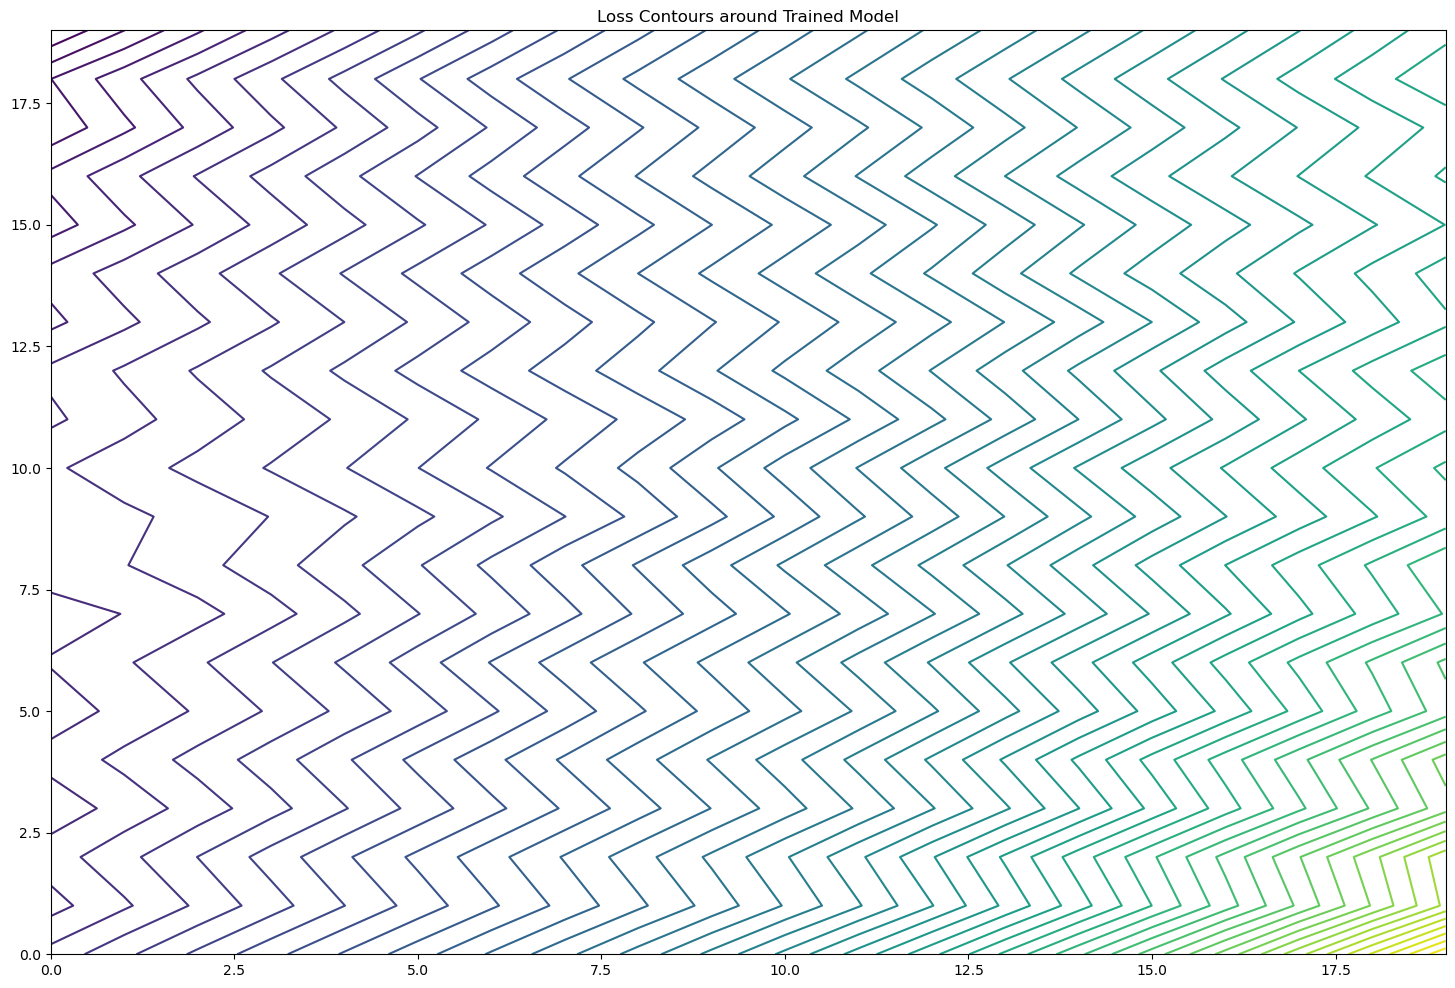

In [39]:
plt.contour(loss_data_diff, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

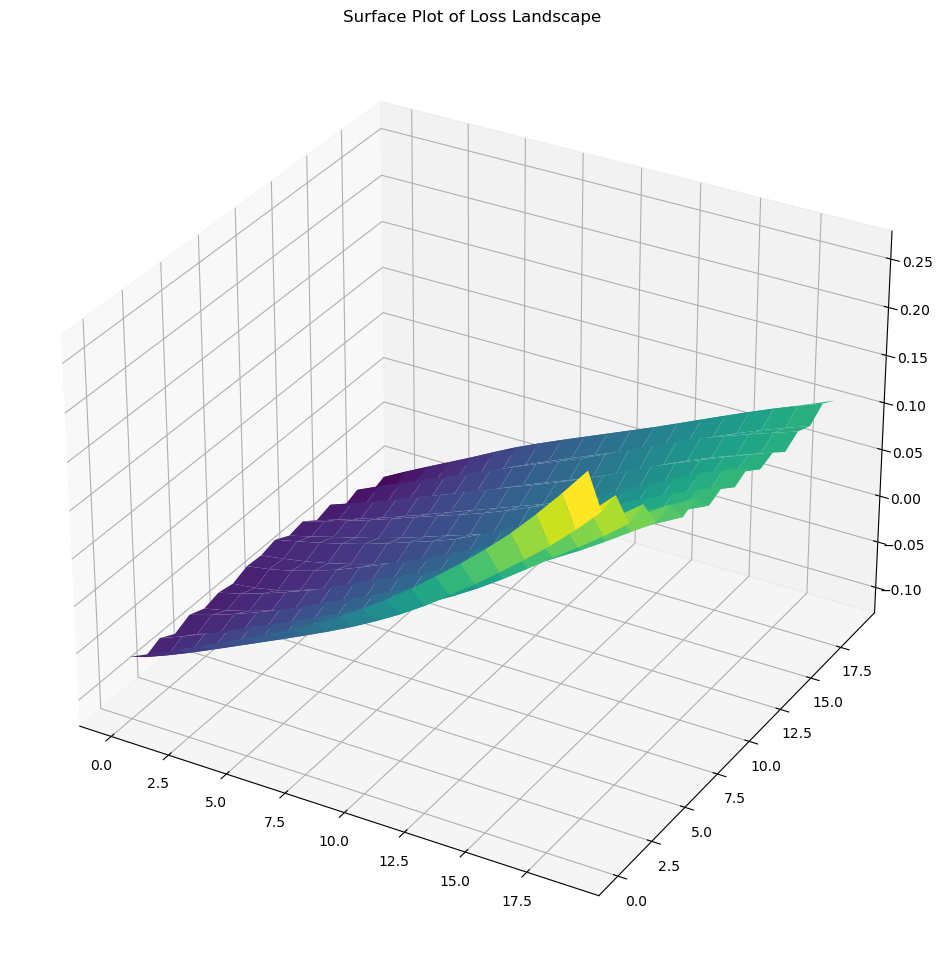

In [40]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_diff, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

## 6. Perturb CRF Only

### 6.1 PyHessian Directions and Spectrum

In [41]:
hessian_comp = hessian(crf_final,
                       criterion,
                       data=(x.to(device), y.to(device)),
                       device=device)
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)

dir_one = ModelParameters(top_eigenvector[0])
dir_two = ModelParameters(top_eigenvector[1])

In [42]:
trace = hessian_comp.trace()
print("The trace of this model is: %.4f"%(np.mean(trace)))

The trace of this model is: 2.3405


In [43]:
density_eigen, density_weight = hessian_comp.density()

In [44]:
density, grids = density_generate(density_eigen, density_weight)

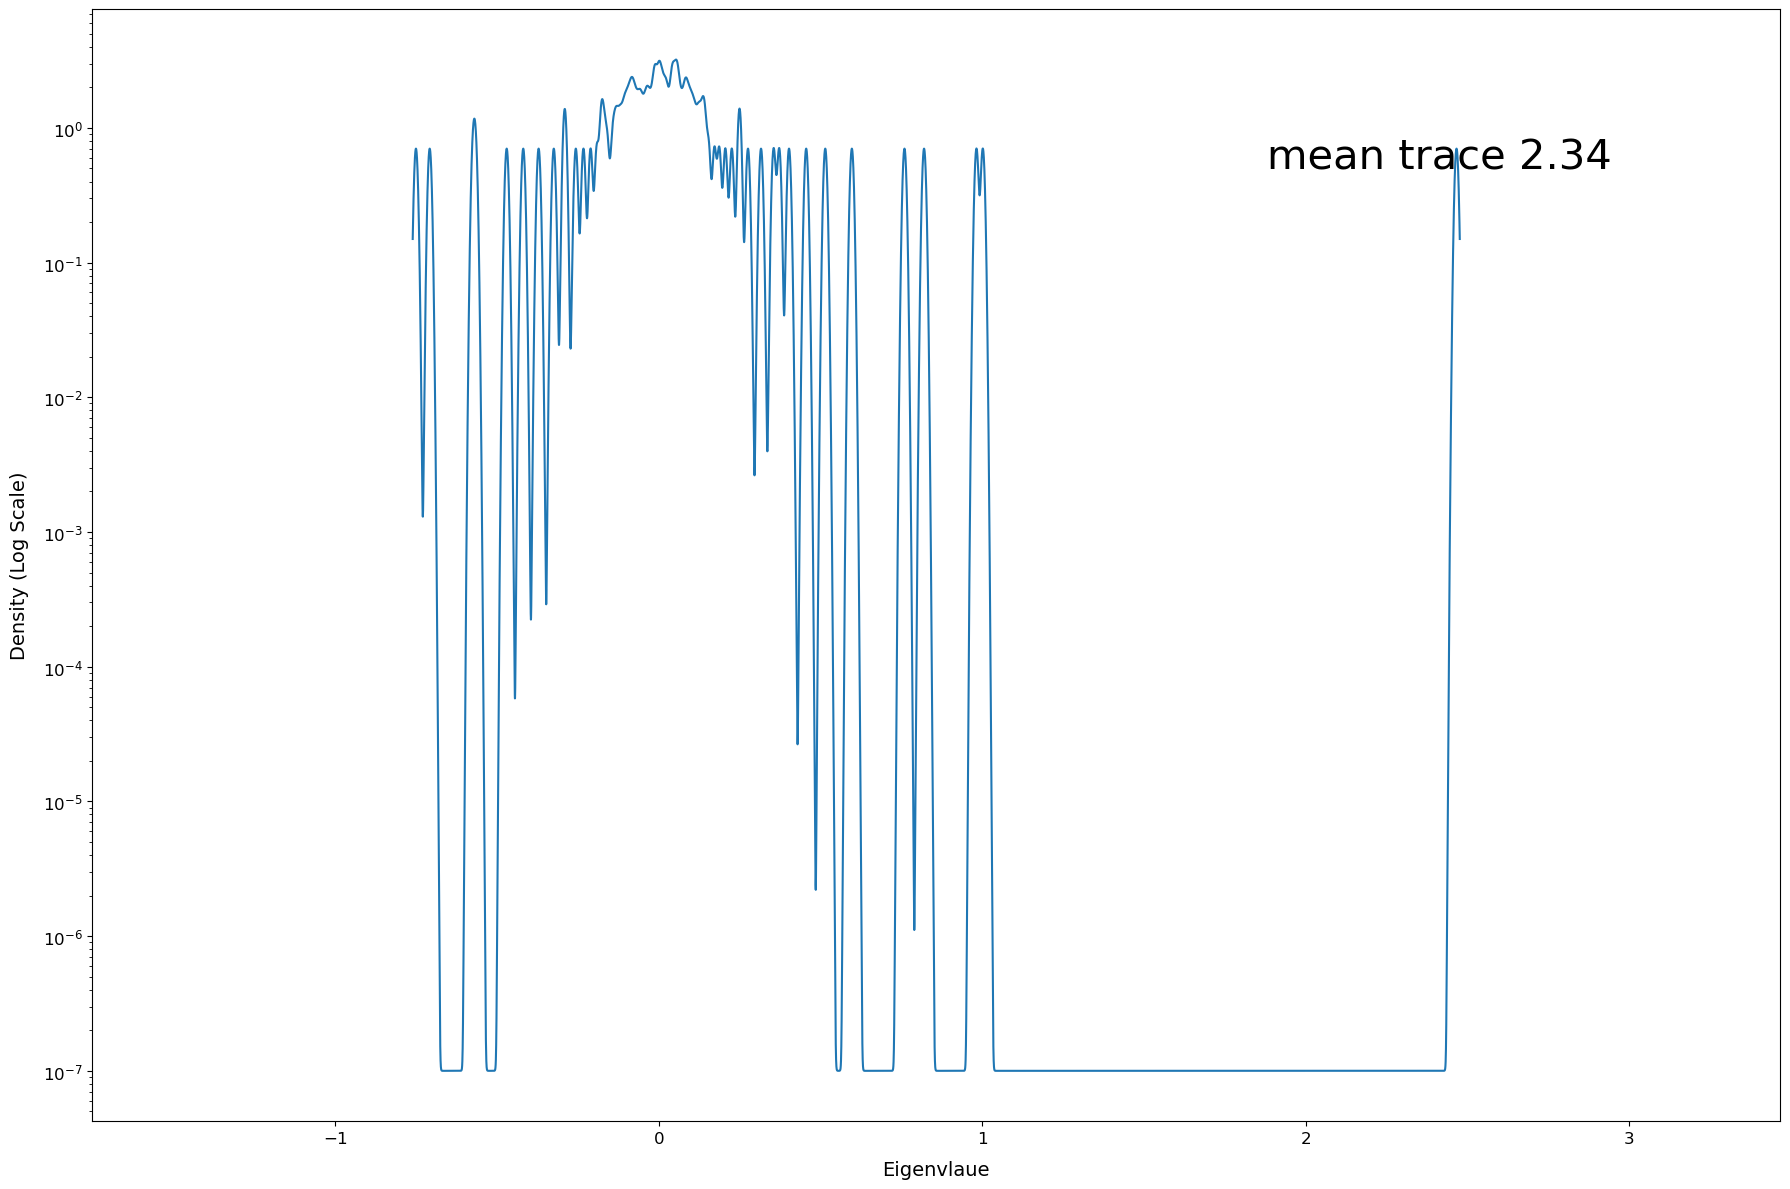

In [45]:
plt.semilogy(grids, density + 1.0e-7)
plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
plt.xlabel('Eigenvlaue', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axis([np.min(density_eigen) - 1, np.max(density_eigen) + 1, None, None])
plt.text(
        (np.max(density_eigen)+1)*0.85,
        1 - 0.5,
        ("mean trace %.2f" % np.mean(trace)).lstrip("0"),
        size=30,
        horizontalalignment="right",
    )
plt.tight_layout()
plt.show()

### 6.2. 2D Loss Landscape by PyHessian Directions

In [46]:
class CRFPerturbLoss(Metric):
    """ Computes a specified loss function over specified input-output pairs, using a backbone network and only perturb CRF."""
    def __init__(self, backbone, loss_fn, inputs: torch.Tensor, target: torch.Tensor):
        super().__init__()
        self.backbone = backbone
        self.loss_fn = loss_fn
        self.inputs = inputs
        self.target = target

    def __call__(self, model_wrapper: ModelWrapper) -> float:
        self.backbone.eval()
        with torch.no_grad():
            intermediate = self.backbone.forward(self.inputs)
        return self.loss_fn(model_wrapper.forward(intermediate), self.target).item()

In [47]:
crf_metric = CRFPerturbLoss(unet_final, criterion, x.to(device), y.to(device))

In [48]:
# compute loss data
pll_crf_only = loss_landscapes.PlanarLossLandscape(crf_final, STEPS, deepcopy_model=True)
pll_crf_only.precomputed(dir_one, dir_two, distance=DIST, normalization=NORM, centered=True)
pll_crf_only.stats_initializer()

In [49]:
# single batch loss landscape
since = time.time()
pll_crf_only.warm_up(crf_metric)
print('warmup time cost ', time.time()-since)

since = time.time()
loss_data_crf_only = pll_crf_only.compute(crf_metric)
print('compute time cost ', time.time()-since)

warmup time cost  41.31932091712952
compute time cost  41.487701416015625


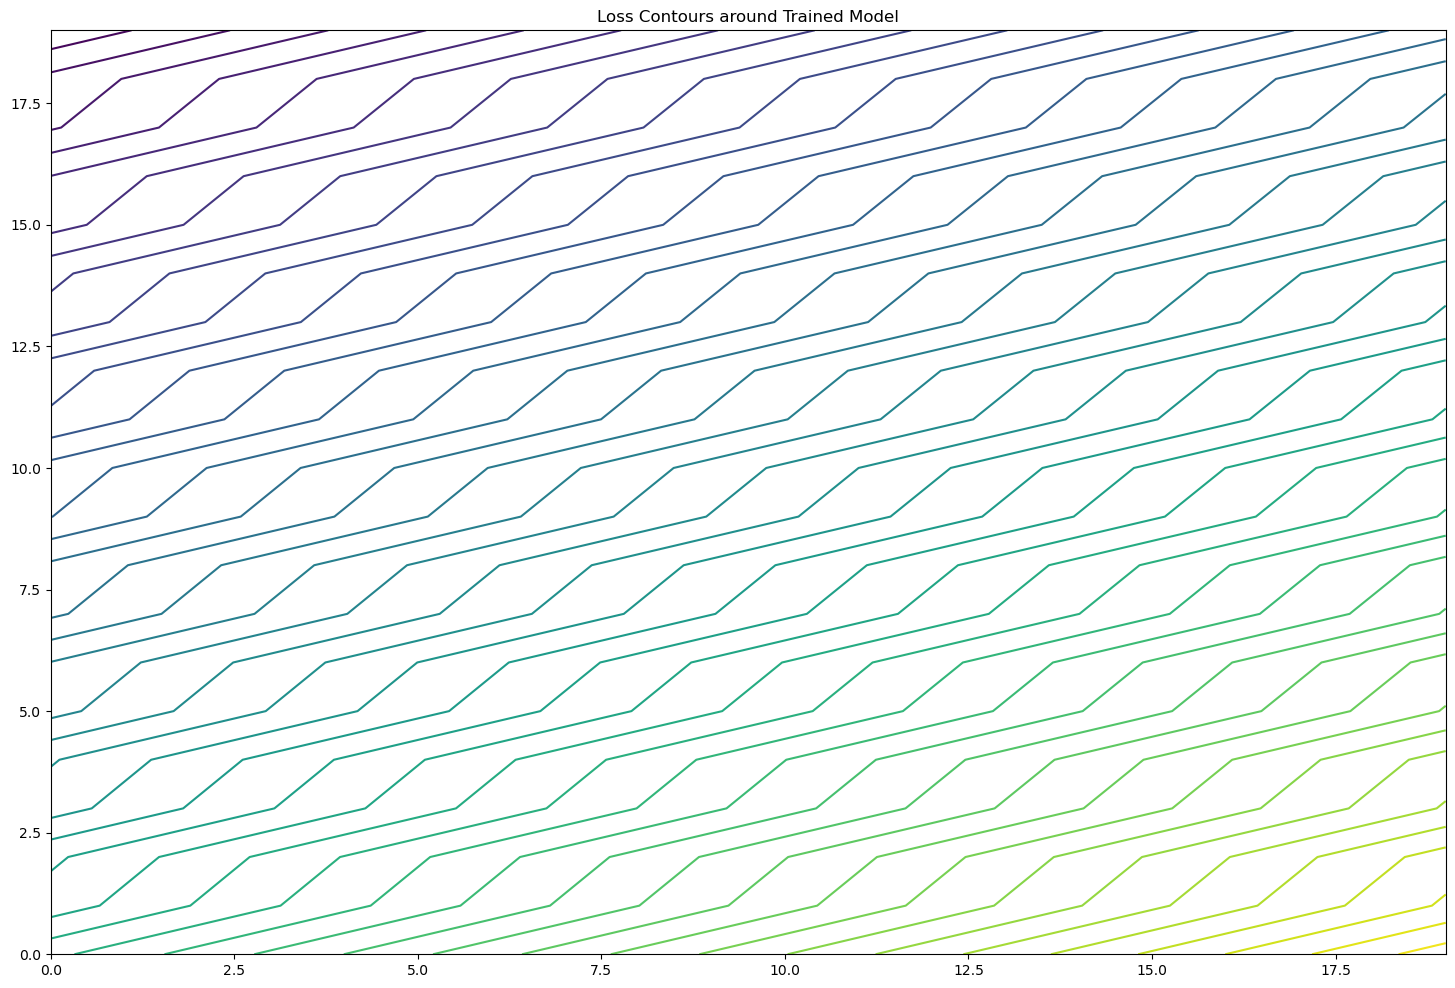

In [50]:
plt.contour(loss_data_crf_only, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

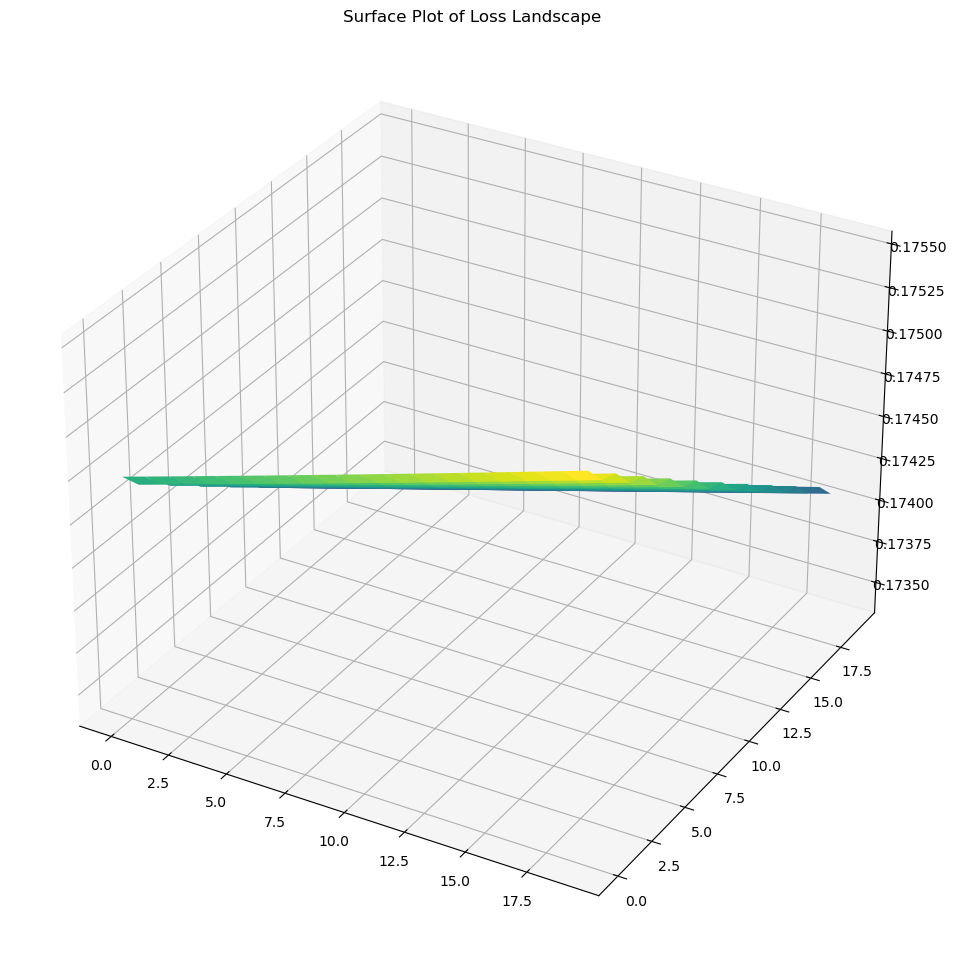

In [51]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_crf_only, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

In [52]:
with open('pyhessian-unet-only-crf-loss-landscape.npy', 'wb') as f:
    np.save(f, loss_data_crf_only)

## 7. Perturb UNet Only

### 7.1 PyHessian Directions and Spectrum

In [53]:
hessian_comp = hessian(unet_final,
                       criterion,
                       data=(x.to(device), y.to(device)),
                       device=device)
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)

dir_one = ModelParameters(top_eigenvector[0])
dir_two = ModelParameters(top_eigenvector[1])

In [54]:
trace = hessian_comp.trace()
print("The trace of this model is: %.4f"%(np.mean(trace)))

The trace of this model is: 415.1193


In [55]:
density_eigen, density_weight = hessian_comp.density()

In [56]:
density, grids = density_generate(density_eigen, density_weight)

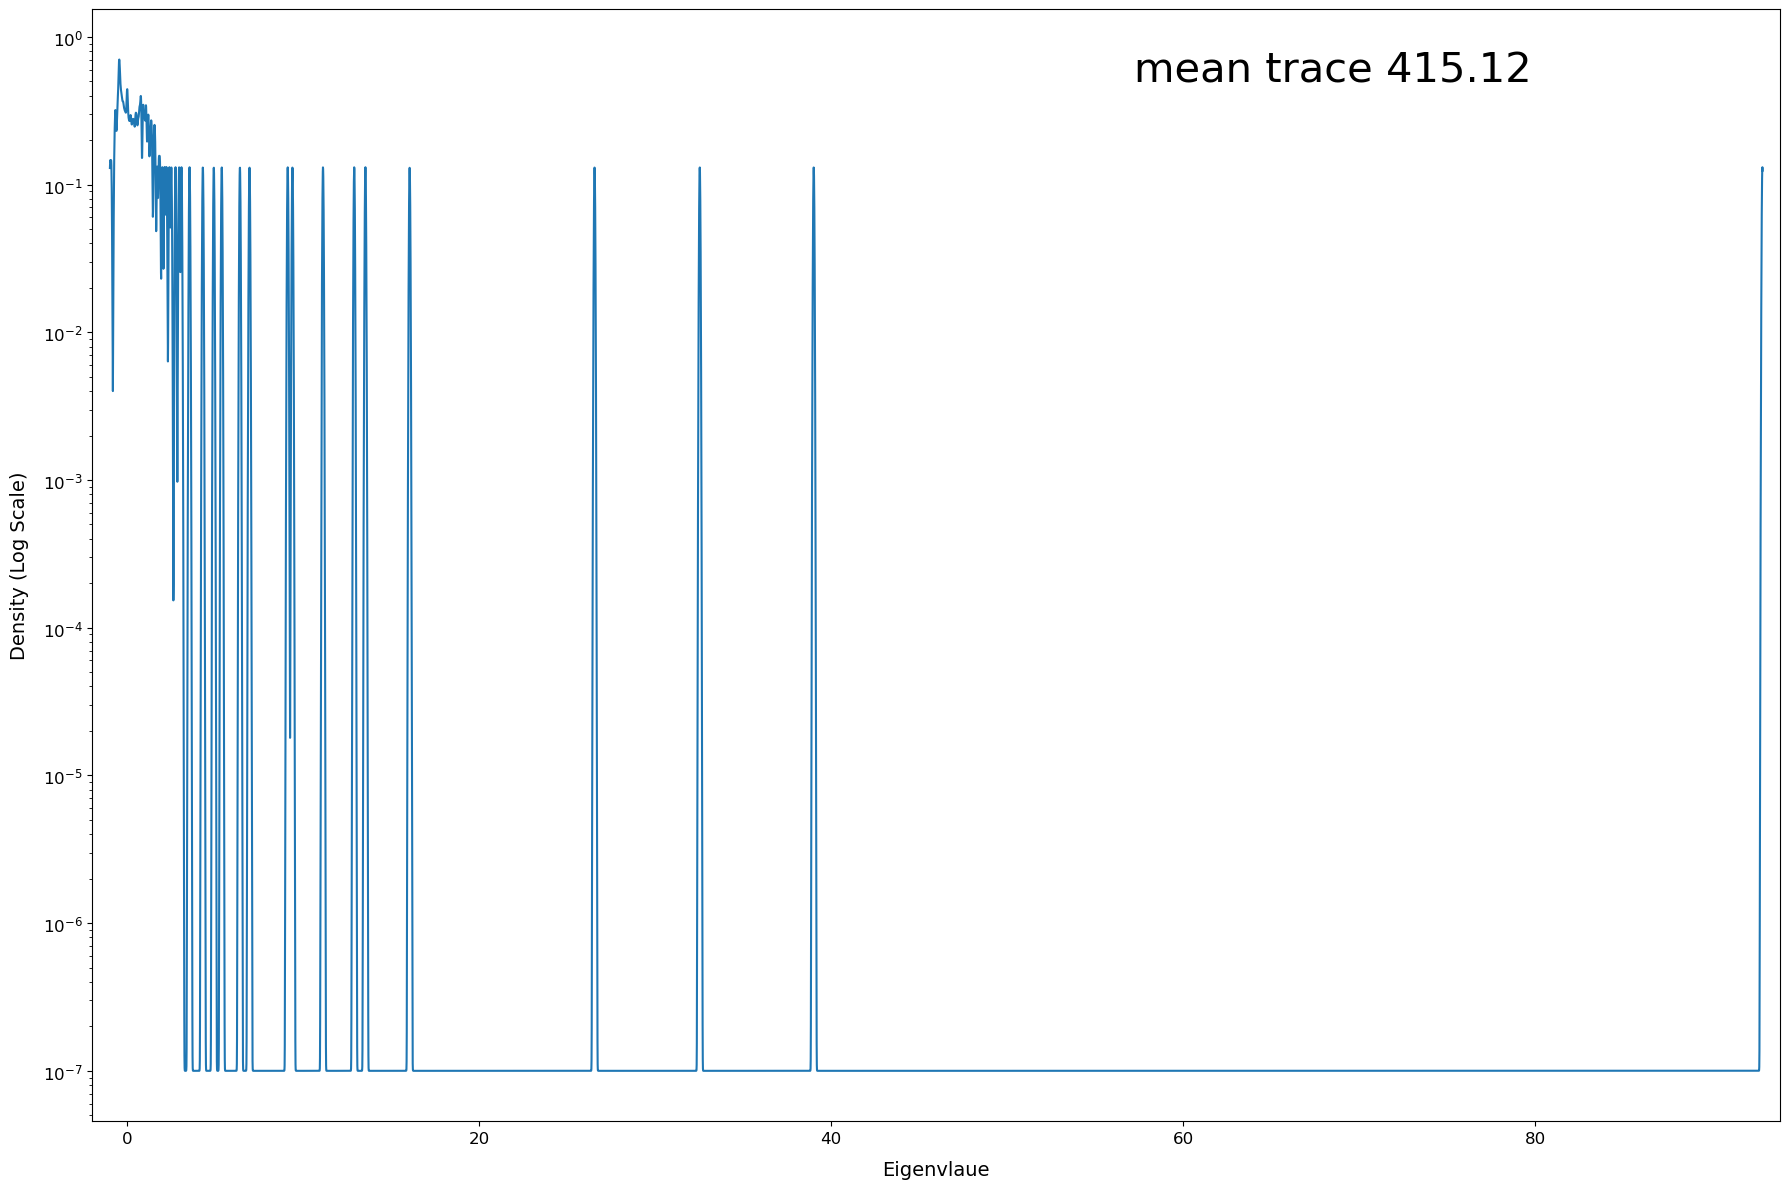

In [57]:
plt.semilogy(grids, density + 1.0e-7)
plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
plt.xlabel('Eigenvlaue', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axis([np.min(density_eigen) - 1, np.max(density_eigen) + 1, None, None])
plt.text(
        (np.max(density_eigen)+1)*0.85,
        1 - 0.5,
        ("mean trace %.2f" % np.mean(trace)).lstrip("0"),
        size=30,
        horizontalalignment="right",
    )
plt.tight_layout()
plt.show()

### 7.2. 2D Loss Landscape by PyHessian Directions

In [58]:
class BackbonePerturbLoss(Metric):
    """ Computes a specified loss function over specified input-output pairs, using a backbone network and only perturb CRF."""
    def __init__(self, crf, loss_fn, inputs: torch.Tensor, target: torch.Tensor):
        super().__init__()
        self.crf = crf
        self.loss_fn = loss_fn
        self.inputs = inputs
        self.target = target

    def __call__(self, model_wrapper: ModelWrapper) -> float:
        intermediate = model_wrapper.forward(self.inputs)
        self.crf.eval()
        with torch.no_grad():
            loss = self.loss_fn(self.crf.forward(intermediate), self.target).item()
        return loss

In [59]:
unet_metric = BackbonePerturbLoss(crf_final, criterion, x.to(device), y.to(device))

In [60]:
# compute loss data
pll_unet_only = loss_landscapes.PlanarLossLandscape(unet_final, STEPS, deepcopy_model=True)
pll_unet_only.precomputed(dir_one, dir_two, distance=DIST, normalization=NORM, centered=True)
pll_unet_only.stats_initializer()

In [61]:
# single batch loss landscape
since = time.time()
pll_unet_only.warm_up(unet_metric)
print('warmup time cost ', time.time()-since)

since = time.time()
loss_data_unet_only = pll_unet_only.compute(unet_metric)
print('compute time cost ', time.time()-since)

warmup time cost  44.666828870773315
compute time cost  42.48172163963318


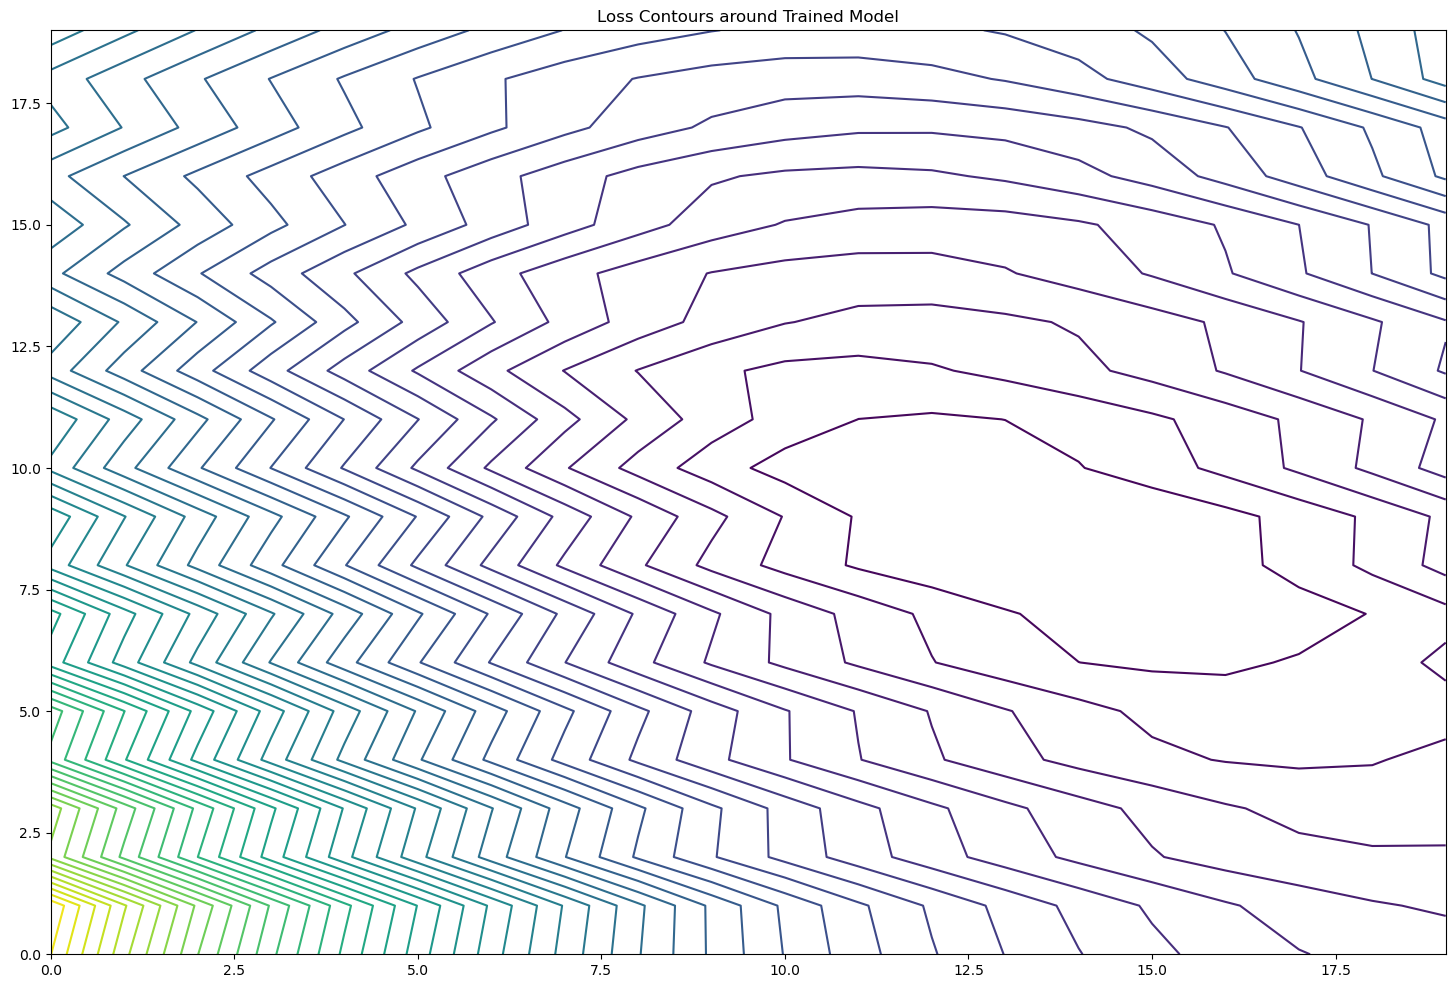

In [62]:
plt.contour(loss_data_unet_only, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

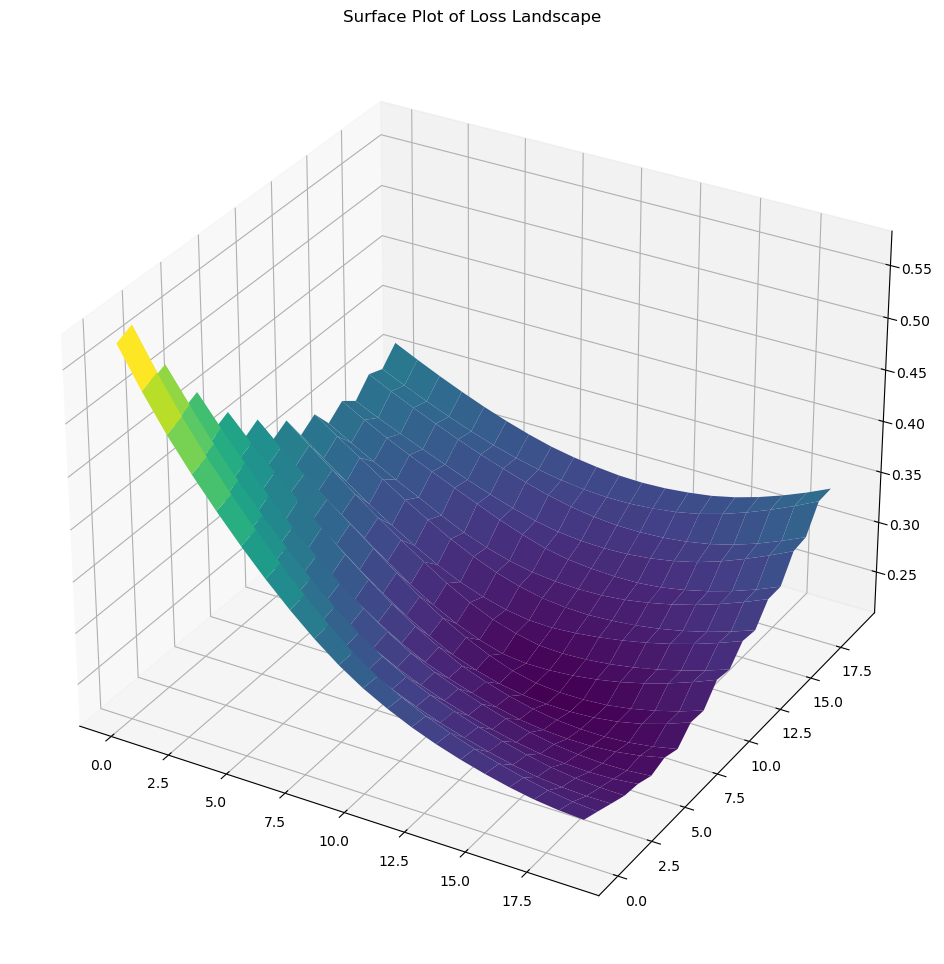

In [63]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_unet_only, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

In [64]:
with open('pyhessian-unet-only-unet-loss-landscape.npy', 'wb') as f:
    np.save(f, loss_data_unet_only)